In [1]:
import pandas as pd
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Acquire
We'll start by loading up the data from our acquire module.

In [2]:
df = get_store_data()
df.head(3)

Data is cached. Reading from .csv files
Items data acquired...
Stores data acquired...
Sales data acquired...
Acquisition complete


,Unnamed: 0_x,sale_amount,sale_date,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
0,0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253


## Summarize
Before we dive into the data preperation, we should get an idea of the shape of the data. We'll get a sense for the number of rows, column names, datatypes, descriptive statistics, number and percent of missing values. We'll also get a broad overview of the kind of data in each column.

In [3]:
df.shape # number of rows and columns

(913000, 17)

In [4]:
df.head()

,Unnamed: 0_x,sale_amount,sale_date,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
0,0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
3,3,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
4,4,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253


In [5]:
df.isnull().sum() # number null values in each column

Unnamed: 0_x     0
sale_amount      0
sale_date        0
sale_id          0
Unnamed: 0_y     0
item_brand       0
item_id          0
item_name        0
item_price       0
item_upc12       0
item_upc14       0
Unnamed: 0       0
store_address    0
store_city       0
store_id         0
store_state      0
store_zipcode    0
dtype: int64

In [6]:
df.dtypes

Unnamed: 0_x       int64
sale_amount      float64
sale_date         object
sale_id            int64
Unnamed: 0_y       int64
item_brand        object
item_id            int64
item_name         object
item_price       float64
item_upc12         int64
item_upc14         int64
Unnamed: 0         int64
store_address     object
store_city        object
store_id           int64
store_state       object
store_zipcode      int64
dtype: object

Date is not a datetime object yet. We have multiple, redundant indices. Need to convert date to date, reindex, and maybe drop original index columns

In [7]:
df.store_id.unique() # unique values of  store_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [8]:
df.item_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [9]:
df.sale_date.nunique() # number of unique sales dates

1826

In [10]:
df.sale_date.min(), df.sale_date.max()

('Fri, 01 Apr 2016 00:00:00 GMT', 'Wed, 31 May 2017 00:00:00 GMT')

In [11]:
df.sale_amount.describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sale_amount, dtype: float64

#### Takeaways so far:

- 913k rows
- No missing values
- `store_id` ranges from 1-10
- `item_id` ranges from 1-50
- 1826 unique days
- `sale_amount` ranges from 0-231

## Prepare
The most common activity in preparing time series data is setting dates to datetime types using `pd.to_datetime`.

Another common activity is looking at the frequency of the data and gaps in time or null values. As part of this, we'll investigate our data and figure out what each row represents and ask if that is what we want.

### Set Datetime Index

In [12]:
# Reassign the sale_date column to be a datetime type
df.sale_date = pd.to_datetime(df.sale_date)

# Sort rows by the date and then set the index as that date
df = df.set_index("sale_date").sort_index()

### Defining Our Observations
Here we ask ourselves what each row (or observation) represents or measures.

In [14]:
df.head()

,Unnamed: 0_x,sale_amount,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,0,13.0,1,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2013-01-01 00:00:00+00:00,211816,26.0,211817,11,Mueller,12,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,6,12018 Perrin Beitel Rd,San Antonio,7,TX,78217
2013-01-01 00:00:00+00:00,832656,27.0,832657,45,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,6,12018 Perrin Beitel Rd,San Antonio,7,TX,78217
2013-01-01 00:00:00+00:00,213642,54.0,213643,11,Mueller,12,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,7,15000 San Pedro Ave,San Antonio,8,TX,78232
2013-01-01 00:00:00+00:00,215468,35.0,215469,11,Mueller,12,Mueller Sport Care Basic Support Level Medium Elastic Knee Support,8.40,74676640211,74676640211,8,735 SW Military Dr,San Antonio,9,TX,78221


Notice that each row is not a single day. With datetime indices, we can have multiple rows at the same datetime value. It looks like each individual row, that is, each observation, is a sales of a specific item at a specific store, one sale.

We can confirm this by taking a look at the sale_id column.

In [15]:
df.shape[0], df.sale_id.nunique()

(913000, 913000)

It looks like each sale id does uniquely identify each row and each row is a combination of one item sold at one store. So each observation is the **quantity** of items sold on **one** day, in **one** store.

### Let's get to know our data a bit better
Currently, the dataframe has one row per sold item, but what if we need more or less granularity?

Let's get to know our data then consider what it means to define our observation in different ways.

We'll also look at different time-windows for our data.

### Plot Target Variable Over Time
Generate a quick plot of our target variable over time, the variable we wish to forecast or predict. We will first aggregate the `sale_amount` by `sale_date` using `sum()`, i.e. group by sale_date and sum the sale_amount. We will then do a quick plot of this aggregated data.

In [16]:
by_date = df.groupby(['sale_date']).sale_amount.sum().reset_index()
by_date.head()

,sale_date,sale_amount
0,2013-01-01 00:00:00+00:00,13696.0
1,2013-01-02 00:00:00+00:00,13678.0
2,2013-01-03 00:00:00+00:00,14488.0
3,2013-01-04 00:00:00+00:00,15677.0
4,2013-01-05 00:00:00+00:00,16237.0


NumExpr defaulting to 8 threads.


<AxesSubplot:xlabel='sale_date'>

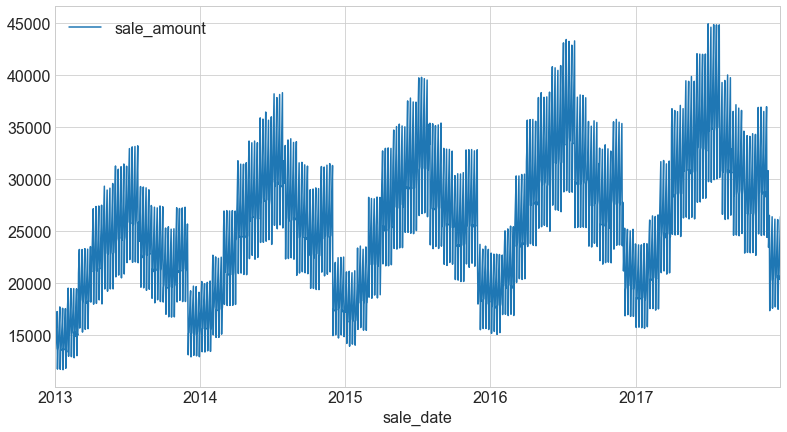

In [17]:
by_date.plot(x='sale_date', y='sale_amount')

Is each store equally represented in this dataset?

In [18]:
# Number of observations per store = number of item-transactions per store.
df.store_id.value_counts()

1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store_id, dtype: int64

Is each item equally represented in this dataset?

In [19]:
df.item_id.value_counts().sort_index()

1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: item_id, dtype: int64

It looks like both items and stores are equally represented, that is, each store shows up the same number of times and so does each item.

### Explore Stores + Items
There are 50 different items and there were 18,260 sales for each item.

We will explore the data behind the unique combinations of store & item.
For example, what was the first sale date for each store/item combination? What was the last sale date?
On how many different days was each item sold at each store?

First, we will want to reset the index so that `sale_date` becomes a feature we can use in an aggregate.
Next, we will group by `store_id` and `item_id`. Finally, we will perform the aggregates needed to answer the questions.

Let's find the first sale date for each store/item combination:

In [20]:
first_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.min()
first_sale.head()

store_id  item_id
1         1         2013-01-01 00:00:00+00:00
          2         2013-01-01 00:00:00+00:00
          3         2013-01-01 00:00:00+00:00
          4         2013-01-01 00:00:00+00:00
          5         2013-01-01 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, UTC]

Is Jan 1, 2013 the first date for all store/item combinations?

In [21]:
# get the unique dates from first_sale_per_storeitem
first_sale.unique() # if there's only one unique value, then YES!

<DatetimeArray>
['2013-01-01 00:00:00+00:00']
Length: 1, dtype: datetime64[ns, UTC]

What is the last (i.e. most recent) sale date for each store/item combination?

In [22]:
last_sale = df.reset_index().groupby(['store_id','item_id']).sale_date.max()
last_sale.head()

store_id  item_id
1         1         2017-12-31 00:00:00+00:00
          2         2017-12-31 00:00:00+00:00
          3         2017-12-31 00:00:00+00:00
          4         2017-12-31 00:00:00+00:00
          5         2017-12-31 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, UTC]

Is Dec 31, 2107 the last date for all store/item combinations?

In [23]:
last_sale.unique() # if there's only one unique value, then YES!

<DatetimeArray>
['2017-12-31 00:00:00+00:00']
Length: 1, dtype: datetime64[ns, UTC]

On how many different days was each item sold at each store?

In [24]:
days_per_store_per_item = df.reset_index().groupby(['store_id','item_id']).sale_date.nunique()
days_per_store_per_item.head()

store_id  item_id
1         1          1826
          2          1826
          3          1826
          4          1826
          5          1826
Name: sale_date, dtype: int64

Did every store sell at least one of every item on every day in the data's time span?

In [25]:
# If there's only one unique value in the list, then YES!
days_per_store_per_item.unique() 

array([1826])

Every store sold every item on every one of the 1826 days in our data history.

## Check for time gaps in the data

While there might not be nulls present in our data, the time observations may leave a gap that we need to be able to detect. We can check the number of rows vs. the number of days that should exist between the minimum and maximum dates to see if there are any missing days.

In [26]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 1826
Number of days between first and last day: 1826 days 00:00:00


## Reproducibility
We'll now encapsulate all the preparation work that we've done into a single function, and store that function in prepare.py so that we can reference it again later.

In [27]:
def prep_store_data(df):
    # Reassign the sale_date column to be a datetime type
    df.sale_date = pd.to_datetime(df.sale_date)

    # Sort rows by the date and then set the index as that date
    df = df.set_index("sale_date").sort_index()
    return df

## Data Splitting
Splitting time series data into train, test, and validate sets is a little trickier than with previous data we have looked at. Because the data points have an order to them, we cannot simply assign each point randomly to train, validate, or test.

Ideally all splits should contain one season's worth of data. There are several methods we can use to split our time series data:

**Human-based**: use, for example, the last year in the dataset as test split (i.e. use an arbitrary rule based on some convention)

**Percentage based**: use the last 20% as test

**Cross Validate**: break data up into slices and use successive slices as train and test repeatedly (sklearn.model_selection.TimeSeriesSplit)

### Percentage-Based Split

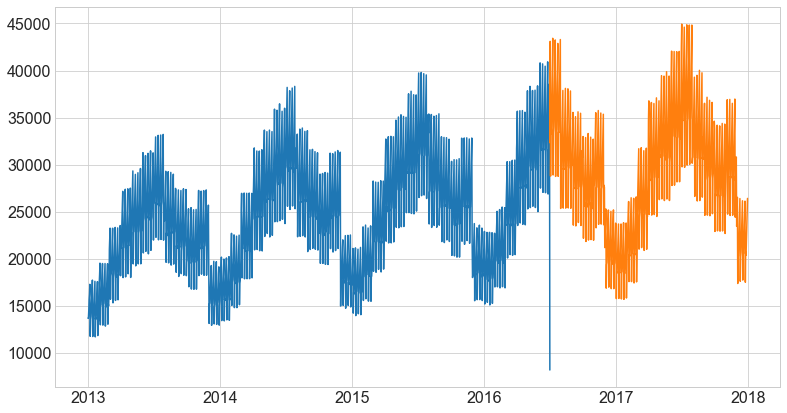

In [28]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

train_by_date = train.groupby(['sale_date']).sale_amount.sum().reset_index()
#train_by_date.plot(x='sale_date', y='sale_amount')

test_by_date = test.groupby(['sale_date']).sale_amount.sum().reset_index()
#test_by_date.plot(x='sale_date', y='sale_amount')

plt.plot(train_by_date.sale_date, train_by_date.sale_amount)
plt.plot(test_by_date.sale_date, test_by_date.sale_amount)
plt.show()

Uh oh. It appears that my percentage-based splitting method is arbitrarily doing something weird to the data. Lets take a closer look:

In [29]:
train_by_date.tail()

,sale_date,sale_amount
1274,2016-06-28 00:00:00+00:00,31539.0
1275,2016-06-29 00:00:00+00:00,31638.0
1276,2016-06-30 00:00:00+00:00,33832.0
1277,2016-07-01 00:00:00+00:00,38583.0
1278,2016-07-02 00:00:00+00:00,8193.0


In [30]:
test_by_date.head()

,sale_date,sale_amount
0,2016-07-02 00:00:00+00:00,32341.0
1,2016-07-03 00:00:00+00:00,43103.0
2,2016-07-04 00:00:00+00:00,28792.0
3,2016-07-05 00:00:00+00:00,33392.0
4,2016-07-06 00:00:00+00:00,33287.0


In [31]:
train.tail(1)

,Unnamed: 0_x,sale_amount,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
sale_date,,,,,,,,,,,,,,,,
2016-07-02 00:00:00+00:00,848542,30.0,848543,46,Bear Naked,47,Bear Naked Fit Almond Crisp 100 Percent Natural Energy Cereal,7.38,884623708976,884623708976,4,1520 Austin Hwy,San Antonio,5,TX,78218


In [32]:
test.head(1)

,Unnamed: 0_x,sale_amount,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
sale_date,,,,,,,,,,,,,,,,
2016-07-02 00:00:00+00:00,41450,67.0,41451,2,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixed Berry,2.43,23923330139,23923330139,2,2118 Fredericksburg Rdj,San Antonio,3,TX,78201


It appears that we are somewhat arbitrarily separating the train set from the test set in the middle of a single date. This will have the unfortunate effect of "teaching" our model to expect a sudden drop. We can fix this by manually shifting the data over a tiny amount to round to the nearest date.

In [33]:
train = df[:'2016-07-01 00:00:00+00:00'] # everything up (not including) to the test_start_index
test = df['2016-07-02 00:00:00+00:00':] # everything from the test_start_index to the end

In [34]:
train.tail(1)

,Unnamed: 0_x,sale_amount,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
sale_date,,,,,,,,,,,,,,,,
2016-07-01 00:00:00+00:00,158313,50.0,158314,8,Van De Kamps,9,Van De Kamps Fillets Beer Battered - 10 Ct,1.79,19600923015,19600923015,6,12018 Perrin Beitel Rd,San Antonio,7,TX,78217


In [35]:
test.head(1)

,Unnamed: 0_x,sale_amount,sale_id,Unnamed: 0_y,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,Unnamed: 0,store_address,store_city,store_id,store_state,store_zipcode
sale_date,,,,,,,,,,,,,,,,
2016-07-02 00:00:00+00:00,225876,154.0,225877,12,Garnier Nutritioniste,13,Garnier Nutritioniste Moisture Rescue Fresh Cleansing Foam,6.47,603084234561,603084234561,3,516 S Flores St,San Antonio,4,TX,78204


Let's revisualize the split with the adjusted cutoff:

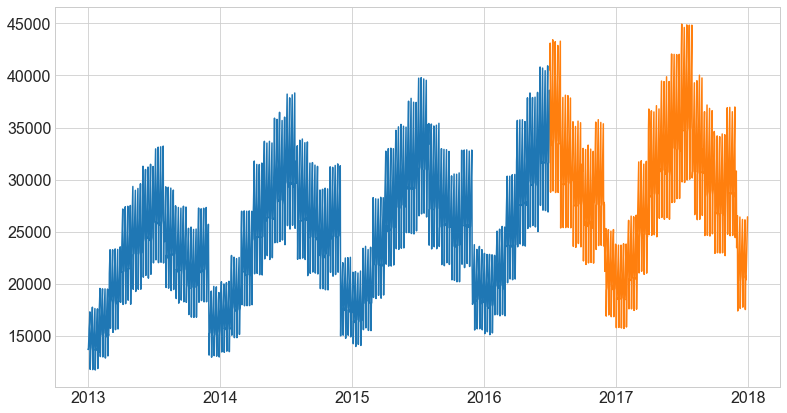

In [36]:
train_by_date = train.groupby(['sale_date']).sale_amount.sum().reset_index()
#train_by_date.plot(x='sale_date', y='sale_amount')

test_by_date = test.groupby(['sale_date']).sale_amount.sum().reset_index()
#test_by_date.plot(x='sale_date', y='sale_amount')

plt.plot(train_by_date.sale_date, train_by_date.sale_amount)
plt.plot(test_by_date.sale_date, test_by_date.sale_amount)
plt.show()

## Human-Based Split

We can arbitrarily decide to split based on the last year:

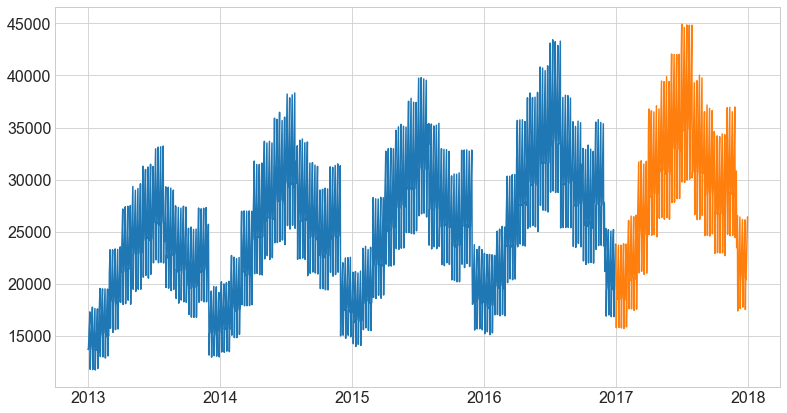

In [37]:
train = df[:'2016'] # includes 2016
test = df['2017']

train_by_date = train.groupby(['sale_date']).sale_amount.sum().reset_index()
#train_by_date.plot(x='sale_date', y='sale_amount')

test_by_date = test.groupby(['sale_date']).sale_amount.sum().reset_index()
#test_by_date.plot(x='sale_date', y='sale_amount')

plt.plot(train_by_date.sale_date, train_by_date.sale_amount)
plt.plot(test_by_date.sale_date, test_by_date.sale_amount)
plt.show()

## Cross-Validated Splitting Using `sklearn`

In [38]:
from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
tscv = TimeSeriesSplit(n_splits)

In [39]:
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(f"Length of TRAIN: {len(train_index)}", f"Length of TEST: {len(test_index)}", "\n")

TRAIN: [     0      1      2 ... 152167 152168 152169] TEST: [152170 152171 152172 ... 304333 304334 304335]
Length of TRAIN: 152170 Length of TEST: 152166 

TRAIN: [     0      1      2 ... 304333 304334 304335] TEST: [304336 304337 304338 ... 456499 456500 456501]
Length of TRAIN: 304336 Length of TEST: 152166 

TRAIN: [     0      1      2 ... 456499 456500 456501] TEST: [456502 456503 456504 ... 608665 608666 608667]
Length of TRAIN: 456502 Length of TEST: 152166 

TRAIN: [     0      1      2 ... 608665 608666 608667] TEST: [608668 608669 608670 ... 760831 760832 760833]
Length of TRAIN: 608668 Length of TEST: 152166 

TRAIN: [     0      1      2 ... 760831 760832 760833] TEST: [760834 760835 760836 ... 912997 912998 912999]
Length of TRAIN: 760834 Length of TEST: 152166 



### Visualizing Cross-Validated Splits

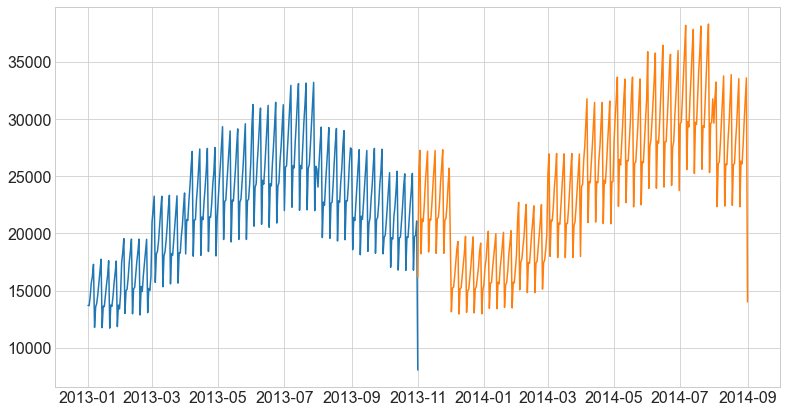

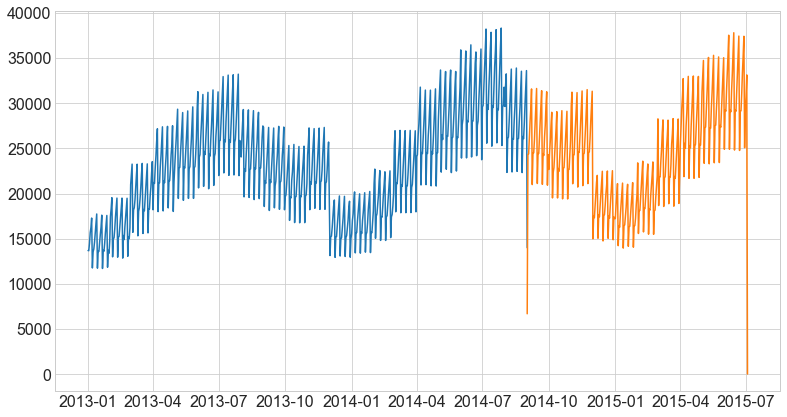

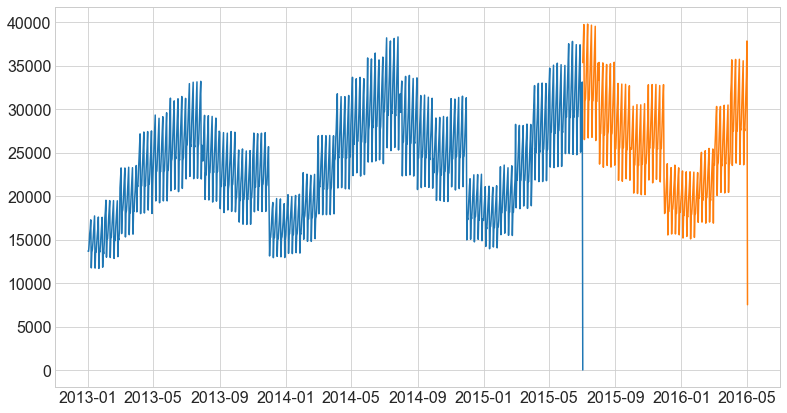

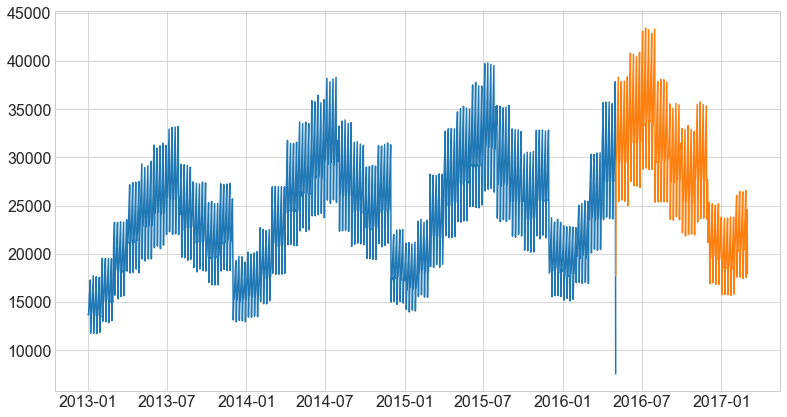

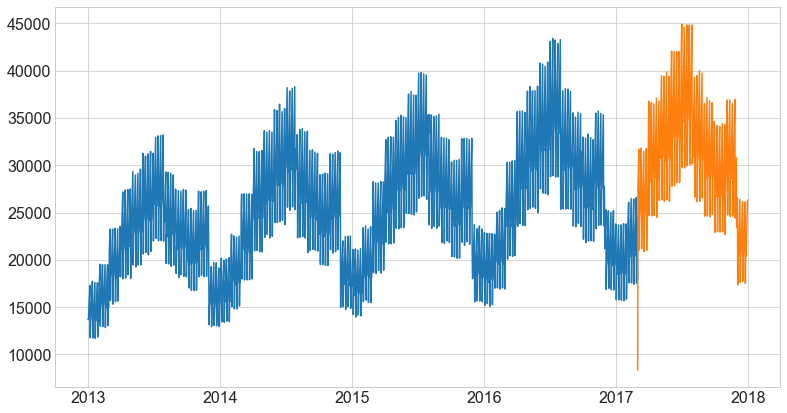

In [40]:
for train_index, test_index in tscv.split(df):
    train = df[:train_index[-1]]
    test = df[test_index[0]:test_index[-1]]

    train_by_date = train.groupby(['sale_date']).sale_amount.sum().reset_index()
    #train_by_date.plot(x='sale_date', y='sale_amount')

    test_by_date = test.groupby(['sale_date']).sale_amount.sum().reset_index()
    #test_by_date.plot(x='sale_date', y='sale_amount')

    plt.plot(train_by_date.sale_date, train_by_date.sale_amount)
    plt.plot(test_by_date.sale_date, test_by_date.sale_amount)
    plt.show()

Notice that we still have the same issue we ran into before. If we want to use this method and we don't want to split in the middle of a day, we will need to either algorithmically or manually tweak the split points.

# Exercises
The end result of this exercise should be a file named `prepare.py`.

**Using your store items data:**

- Convert date column to datetime format.
- Plot the distribution of sale_amount and item_price.
- Set the index to be the datetime variable.
- Add a 'month' and 'day of week' column to your dataframe.
- Add a column to your dataframe, sales_total, which is a derived from sale_amount (total items) and item_price.
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.

**Using the OPS data acquired in the Acquire exercises opsd_germany_daily.csv, complete the following:**

- Convert date column to datetime format.
- Plot the distribution of each of your variables.
- Set the index to be the datetime variable.
- Add a month and a year column to your dataframe.
- Fill any missing values.
- Make sure all the work that you have done above is reproducible. That is, you should put the code above into separate functions and be able to re-run the functions and get the same results.